In [ ]:
!nvidia-smi

Fri Jun  3 09:05:46 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import tensorflow as tf 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
import pickle
from keras.models import model_from_json
from keras.models import load_model
import matplotlib.pyplot as plt
import numpy as np
import tensorflow_hub as hub

In [ ]:
IMAGE_SHAPE = (224, 224)
EPOCHS = 10

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
data_root=("/content/drive/MyDrive/Dataset/Rice Leaf Disease Image Samples/Rice Leaf Disease Images")

In [ ]:
TRAINING_DATA_DIR = str(data_root)

In [ ]:
datagen_kwargs = dict(rescale=1./255, validation_split=.20)

In [ ]:
valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_kwargs)

valid_generator = valid_datagen.flow_from_directory(TRAINING_DATA_DIR, subset= 'validation', shuffle=True, target_size=IMAGE_SHAPE)

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_kwargs)

train_generator = train_datagen.flow_from_directory(TRAINING_DATA_DIR,subset='training',shuffle=True,target_size=IMAGE_SHAPE)

Found 1310 images belonging to 5 classes.
Found 5248 images belonging to 5 classes.


In [ ]:
for image_batch, label_batch in train_generator:
    break
image_batch.shape, label_batch.shape

((32, 224, 224, 3), (32, 5))

In [ ]:
print (train_generator.class_indices)

{'Bacterialblight': 0, 'Blast': 1, 'Brownspot': 2, 'Healthy': 3, 'Tungro': 4}


In [ ]:
labels = '\n'.join(sorted(train_generator.class_indices.keys()))
with open('labels.txt', 'w') as f:
 f.write(labels)
!cat labels.txt

Bacterialblight
Blast
Brownspot
Healthy
Tungro

In [ ]:
model = tf.keras.Sequential([
  hub.KerasLayer('https://tfhub.dev/google/tf2-preview/inception_v3/classification/4', 
  output_shape=[1280],
  trainable=False),
  tf.keras.layers.Dropout(0.4),
  tf.keras.layers.Dense(train_generator.num_classes, activation='softmax')])
model.build([None, 224, 224, 3])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1001)              23853833  
                                                                 
 dropout (Dropout)           (None, 1001)              0         
                                                                 
 dense (Dense)               (None, 5)                 5010      
                                                                 
Total params: 23,858,843
Trainable params: 5,010
Non-trainable params: 23,853,833
_________________________________________________________________


In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(
 optimizer=optimizer,
 loss='categorical_crossentropy',
 metrics=['accuracy',
          tf.keras.metrics.Recall(),
          tf.keras.metrics.Precision()])

In [ ]:
steps_per_epoch = np.ceil(train_generator.samples/train_generator.batch_size)
val_steps_per_epoch = np.ceil(valid_generator.samples/valid_generator.batch_size)
history = model.fit(train_generator, 
   epochs=EPOCHS,
   verbose=1,
   steps_per_epoch=steps_per_epoch,
   validation_data=valid_generator,
   validation_steps=val_steps_per_epoch)

Epoch 1/10
164/164 [==============================] - 1522s 9s/step - loss: 0.9035 - accuracy: 0.7492 - recall_1: 0.7353 - precision_1: 0.7669 - val_loss: 0.2669 - val_accuracy: 0.9076 - val_recall_1: 0.8985 - val_precision_1: 0.9138
Epoch 2/10
164/164 [==============================] - 190s 1s/step - loss: 0.3620 - accuracy: 0.8761 - recall_1: 0.8687 - precision_1: 0.8856 - val_loss: 0.1744 - val_accuracy: 0.9366 - val_recall_1: 0.9336 - val_precision_1: 0.9400
Epoch 3/10
164/164 [==============================] - 184s 1s/step - loss: 0.2629 - accuracy: 0.9053 - recall_1: 0.9007 - precision_1: 0.9122 - val_loss: 0.1463 - val_accuracy: 0.9450 - val_recall_1: 0.9420 - val_precision_1: 0.9500
Epoch 4/10
164/164 [==============================] - 181s 1s/step - loss: 0.2145 - accuracy: 0.9198 - recall_1: 0.9162 - precision_1: 0.9259 - val_loss: 0.1268 - val_accuracy: 0.9527 - val_recall_1: 0.9511 - val_precision_1: 0.9555
Epoch 5/10
164/164 [==============================] - 183s 1s/step 

In [ ]:
final_loss, final_accuracy, final_recall, final_precision = model.evaluate(valid_generator, steps = val_steps_per_epoch)
print('Final loss: {:.2f}'.format(final_loss))
print('Final accuracy: {:.2f}%'.format(final_accuracy * 100))
print('Final Recall: {:.2f}%'.format(final_recall * 100))
print('Final Precision: {:.2f}%'.format(final_precision * 100))

41/41 [==============================] - 37s 898ms/step - loss: 0.0813 - accuracy: 0.9733 - recall_1: 0.9718 - precision_1: 0.9747
Final loss: 0.08
Final accuracy: 97.33%
Final Recall: 97.18%
Final Precision: 97.47%


In [ ]:
final_f1_score = (2 * final_recall * final_precision) / (final_recall + final_precision)
print('Final F-score: {:.2f}%'.format(final_f1_score * 100))

Final F-score: 97.32%


In [ ]:
hist_check = history.history
print(hist_check)

{'loss': [0.9035378694534302, 0.36202767491340637, 0.2628536820411682, 0.21449993550777435, 0.1932801455259323, 0.17839863896369934, 0.175889253616333, 0.16180282831192017, 0.16008581221103668, 0.14214172959327698], 'accuracy': [0.7492377758026123, 0.8761432766914368, 0.9052972793579102, 0.9197789430618286, 0.9310213327407837, 0.9350228905677795, 0.9342606663703918, 0.9405487775802612, 0.9390243887901306, 0.9458841681480408], 'recall_1': [0.7353277206420898, 0.8687118887901306, 0.9007241129875183, 0.9161585569381714, 0.9272103905677795, 0.9323551654815674, 0.9325457215309143, 0.9388338327407837, 0.9357850551605225, 0.9434069991111755], 'precision_1': [0.7668918967247009, 0.8855866193771362, 0.9121960401535034, 0.9258617162704468, 0.9352296590805054, 0.9389752149581909, 0.9382668733596802, 0.9435082077980042, 0.9411652088165283, 0.9477412104606628], 'val_loss': [0.2669375240802765, 0.17436909675598145, 0.14625290036201477, 0.12675359845161438, 0.11533763259649277, 0.10537250339984894, 0

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

recall = history.history['recall_1']
val_recall = history.history['val_recall_1']

precision = history.history['precision_1']
val_precision = history.history['val_precision_1']

f1_score = (2 * np.array(history.history['precision_1']) * np.array(history.history['recall_1'])) / (np.array(history.history['precision_1']) + np.array(history.history['recall_1']))
val_final_f1_score = (2 * np.array(history.history['val_precision_1']) * np.array(history.history['val_recall_1'])) / (np.array(history.history['val_precision_1']) + np.array(history.history['val_recall_1']))

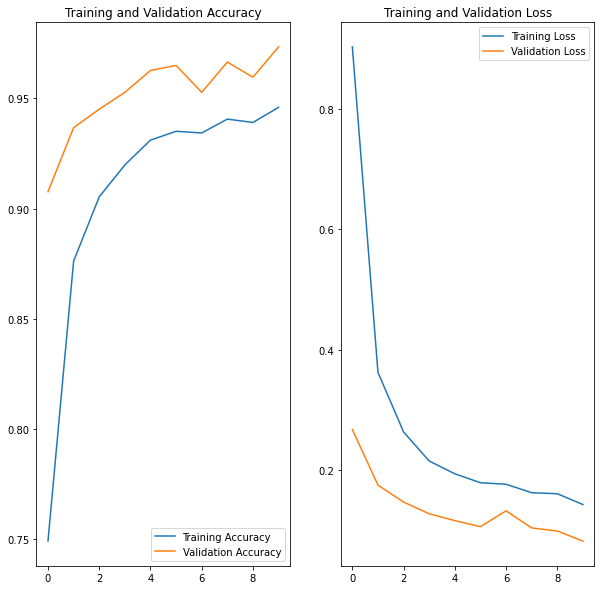

In [ ]:
plt.figure(figsize=(10, 10))

plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

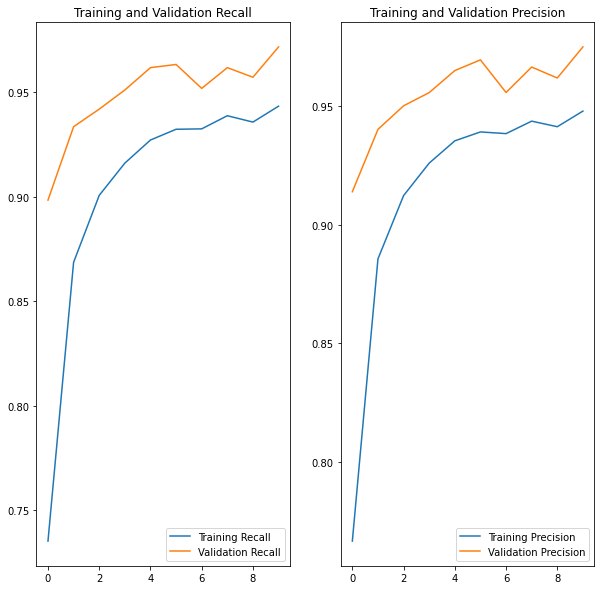

In [ ]:
plt.figure(figsize=(10, 10))

plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), recall, label='Training Recall')
plt.plot(range(EPOCHS), val_recall, label='Validation Recall')
plt.legend(loc='lower right')
plt.title('Training and Validation Recall')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), precision, label='Training Precision')
plt.plot(range(EPOCHS), val_precision, label='Validation Precision')
plt.legend(loc='lower right')
plt.title('Training and Validation Precision')
plt.show()

Text(0.5, 1.0, 'Training and Validation F1-Score')

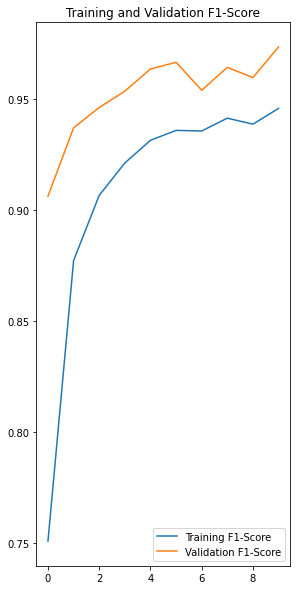

In [ ]:
plt.figure(figsize=(10, 10))

plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), f1_score, label='Training F1-Score')
plt.plot(range(EPOCHS), val_final_f1_score, label='Validation F1-Score')
plt.legend(loc='lower right')
plt.title('Training and Validation F1-Score')